### Import libraries

In [204]:
# import statements
%load_ext autoreload
%load_ext jupyternotify
%autoreload 2
%cd "../../"

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
import scipy.stats as ss
from scipy.io import loadmat
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
/m/home/home5/56


### Generate data

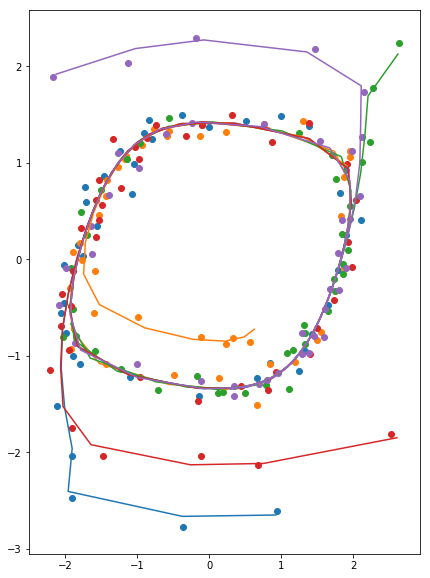

In [205]:
# generate data
use_gpu = 1

class VDP(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([x[:,1:2], 1*(1-x[:,0:1]**2)*x[:,1:2]-x[:,0:1]],1)

class FHN(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([3*(x[:,0:1]-x[:,0:1]**3/3.+x[:,1:2]), (0.2-3*x[:,0:1]-0.2*x[:,1:2])/3.], 1)

class LV(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([1.5*x[:,0:1]-x[:,0:1]*x[:,1:2], -3*x[:,1:2]+x[:,0:1]*x[:,1:2]], 1)
    
from torchdiffeq import odeint_adjoint as odeint
# from torchdiffeq import odeint

device = torch.device('cuda:' + str(use_gpu) if torch.cuda.is_available() else 'cpu')

N = 5
R = 3
x0 = torch.from_numpy(2*R*ss.uniform.rvs(size=[N,2])-R)
# x0 = torch.from_numpy(R*ss.beta.rvs(size=[N,2], a=1, b=1.5)+ [3., 1.5]) # for LV model
t = torch.linspace(0., 7., 40)
# t = torch.linspace(0., 21., 120)

with torch.no_grad():
#     X = odeint(VDP(), x0, t, method='rk4').numpy()
    X = odeint(FHN(), x0, t, method='rk4').numpy()
#     X = odeint(LV(), x0, t, method='rk4').numpy()
    X = np.transpose(X,[1,0,2])
    Y = X + ss.norm.rvs(size=X.shape)*0.1

    
plt.figure(1,[7,10])
for i in range(X.shape[0]):
    plt.plot(X[i,:,0],X[i,:,1],'-')
    plt.scatter(Y[i,:,0],Y[i,:,1])

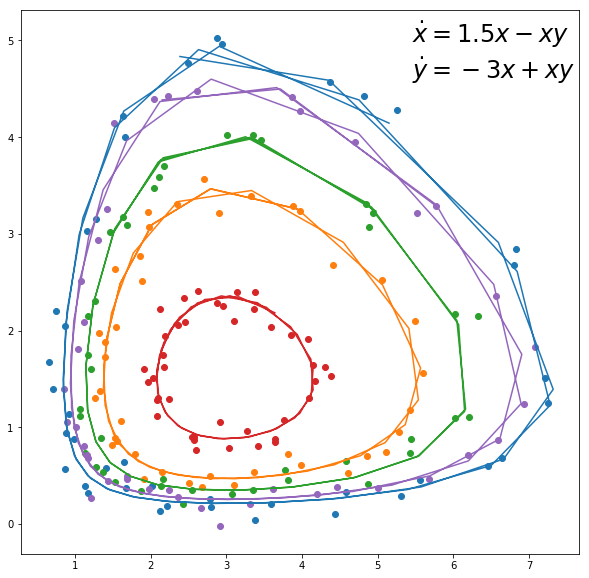

In [230]:
a = pickle.load(open('/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode/data/LV.pickle', 'rb'))
# a = pickle.load(open('/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode/data/VDP.pickle', 'rb'))
a
# a['ODE'] = "VDP"
# pickle.dump(a, open('/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode/VDP.pickle', 'wb'))
with torch.no_grad():
#     X = odeint(VDP(), x0, t, method='rk4').numpy()
    X = a['X']
#     X = odeint(LV(), x0, t, method='rk4').numpy()
#     X = np.transpose(X,[1,0,2])
    Y = a['Y']

    
fig, ax = plt.subplots(1,figsize=[10,10])
# ax.annotate(r'$\dot{x}=y}$' +  '\n'  + '$\dot{y}=(1-x^2)y-x$',
#             xy=(0.63, 0.03), xycoords='axes fraction', fontsize=24,
#              textcoords='offset points',
#             ha='left', va='bottom')
# ax.annotate(r'$\dot{x}=3(x-\frac{x^3}{3}+y)}$' +  '\n'  + '$\dot{y}=(0.2-3x-0.2y)/3$',
#             xy=(0.50, 0.03), xycoords='axes fraction', fontsize=24,
#              textcoords='offset points',
#             ha='left', va='bottom')
ax.annotate(r'$\dot{x}=1.5x-xy$' +  '\n'  + '$\dot{y}=-3x+xy$',
            xy=(0.70, 0.86), xycoords='axes fraction', fontsize=24,
             textcoords='offset points',
            ha='left', va='bottom')
for i in range(X.shape[0]):
    ax.plot(X[i,:,0],X[i,:,1],'-')
    ax.scatter(Y[i,:,0],Y[i,:,1])

## Implementation-1, gradients computed via sensitivities (uses autograd as a subroutine) 

In [174]:
data = {'N': N, 'R': R, 'noise': 0.1, 'x0': x0, 't': t, 'X': X, 'Y': Y}
import os
print(os.getcwd())
pickle.dump(data, open('/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode/LV.pickle', 'wb'))


/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode


### Initialize the model, parameters, variables, etc

In [ ]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
Linv = torch.cholesky(K(Zt,Zt)).inverse()
U0 = torch.mm(Linv,U0) # whitened

class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.Z = Zt
        self.Kzz = K(Zt,Zt)
        self.Kzzinv = self.Kzz.inverse()
        self.L = torch.cholesky(self.Kzz)
        self.KzzinvL = torch.mm(self.Kzzinv,self.L)

    def forward(self, t, X):
        T = torch.mm(K(X,self.Z),self.KzzinvL)
        return torch.mm(T,self.U)

class ODEINT_FS(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, x0, t, th):
        xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
        ctx.func = func
        ctx.save_for_backward(x0,t,th,xode)
        return xode # N,T,D
    @staticmethod
    def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
        # print('backward')
        func = ctx.func
        x0,t,th,xode = ctx.saved_tensors
        N = x0.shape[0]  # problem dimensionality
        D = x0.shape[1]  # problem dimensionality
        MD = torch.numel(th) # number of parameters in the differential function
        with torch.no_grad():
            def ode_sens_rhs(t,xS): # xS = N,D,(1+MD)
                x = xS[:,:,0].view(-1,D) # N,D
                S = xS[:,:,1:] # N,D,MD
                th = list(func.parameters())[0]
                dxs = []
                dSs = []
                for j in range(N):
                    x_ = x[j:j+1].requires_grad_(True) #.detach() # 1,D
                    S_ = S[j] # D,MD
                    J = [] # accumulate columns of J here
                    R = [] # accumulate columns of R here
                    for i in range(D): # partial derivative of output dimension i 
                        with torch.set_grad_enabled(True):
                            f = func(t,x_)[0,i]
                            dfdxth = torch.autograd.grad(f, [x_,th], allow_unused=False, retain_graph=False)
                            J.append(dfdxth[0])
                            R.append(dfdxth[1].view(1,-1)) # 1,MD
                    J = torch.cat(J) # D,D
                    R = torch.cat(R) # D,MD
                    dS = torch.matmul(J,S_)+R # D,MD
                    dx = func(t,x_) # 1,D
                    dxs.append(dx.unsqueeze(2)) # 1,D,1
                    dSs.append(dS.unsqueeze(0)) # 1,D,MD
                dx = torch.cat(dxs) # N,D,1
                dS = torch.cat(dSs) # N,D,MD
                dxdS = torch.cat([dx,dS],2)
                return dxdS
            x0 = torch.unsqueeze(x0,2) # N,D,1
            S0 = torch.zeros(N,D,MD)
            xS0 = torch.cat((x0,S0),2) # N,D,(1+MD)
            xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,N,D,(1+MD)
            xode2 = xS[:,:,:,0].permute([1,0,2]) # N,T,D
            # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
            S = xS[:,:,:,1:].permute([1,2,0,3]) # N,D,T,MD
            # print(grad_output[0].shape) # N,T,D
            dlossdx = grad_output[0].permute([0,2,1]).unsqueeze(3) # N,D,T,1
            dlossdU = torch.sum(S*dlossdx,[0,1,2]) # MD
        return None,None,None,dlossdU # N,T,D
    
odeint_fs = ODEINT_FS.apply
kreg = KernelRegression()

# check why doesn't work
# from torch.autograd import gradcheck
# th_ = _flatten(kreg.parameters())
# test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# print(test)

def odeint_forw_sens(func, x0, t):
    th = _flatten(func.parameters())
    xode = odeint_fs(kreg, x0, t, th)
    return xode
    

### Optimize

In [ ]:
# optimization

logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
params = [kreg.U,logsn]
optimizer = optim.Adam(params, lr=5e-3)

    
for itr in range(500):
    optimizer.zero_grad()
    T   = min(3+itr//10, len(t))
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint_forw_sens(kreg,x0,t_)
    loss = torch.sum((Yt_-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt_)*torch.sum(logsn)/D + \
        torch.sum(torch.diag(torch.mm(kreg.U.t(),kreg.U)))/2
    loss.backward()
    optimizer.step()

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_forw_sens(kreg,x0,t)
            loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    # break
    end = time.time()


### Visualize

In [ ]:
# plotting
xode = odeint_forw_sens(kreg, x0, t).detach().numpy()
U = kreg.U.detach().numpy()
Z = Zt.detach().numpy()

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(Y[i,:,0],Y[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

In [ ]:
for i in range(min(6,xode.shape[0])):
    fig, ax = plt.subplots()
    ax.plot(Y[i,:,0],'o',color=cols[i])
    ax.plot(xode[i,:,0],'-',color=cols[i])

## Implementation-2 that uses Torch autograd, no sensitivities/adjoints 

### Initialize the model, parameters, variables, etc

In [ ]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)
    

Kzzinv = K(Zt, Zt).inverse()

npode = KernelRegression()
# lbfgs = optim.LBFGS(npode.parameters(), lr=1e-3)
optimizer = optim.Adam(npode.parameters(), lr=5e-3)
# optimizer = optim.SGD(npode.parameters(), lr=3e-5)


### Optimize

In [ ]:
# optimization
def closure():
    optimizer.zero_grad()
    xode = odeint(npode, x0, t).permute([1,0,2])
    loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
    loss.backward()
    return loss

    
# n_iters = 1000
n_iters = 1000

## learning rate scheduling for sgd+momentum and rmsprop
lr = 5e-4
lr_decay=0.03

## Momentum schedulin for sgd+momentum
mom_init = 0.5
mom_final = 0.99
mom_decay = 0.03

for itr in range(n_iters):
    optimizer.zero_grad()

#     for g in optimizer.param_groups:
#         g['lr'] = lr/(1+lr_decay*i)
#     for g in optimizer.param_groups:
#         g['momentum'] = mom_final - (mom_final-mom_init)/(1+mom_decay*i)

    xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn)**2) +  torch.numel(Xt)*torch.sum(npode.logsn)/D + \
        torch.sum(torch.diag(torch.mm(npode.U.t(), torch.mm(Kzzinv, npode.U))))/2
    loss.backward()
    optimizer.step()
#     lbfgs.step(closure)

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
            if torch.isnan(loss):
                %notify -m "Nan encountered in loss"
                break
            loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    end = time.time()

### Visualize

In [ ]:
# plotting
xode = odeint(npode, x0, t).detach().numpy()
U = npode.U.detach().numpy()
Z = npode.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(Y[i,:,0],Y[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

In [ ]:
torch.exp(npode.logsn)

## Inference using MCMC

In [134]:

# create variables, functions etc
M   = 5 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75
# ell = 1

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2)+np.log(0.05), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f|
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)

kreg = KernelRegression()
Kzzinv = K(Zt, Zt).inverse()
# lbfgs = optim.LBFGS(npode.parameters(), lr=5e-3)
# optimizer = optim.Adam(npode.parameters(), lr=5e-3)

### Inference

itr = 0


def closure(add_prior=True):
    global itr
#     T   = min(3+itr//10, len(t))
    T   = len(t)
    itr += 1
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint(kreg, x0, t_, method='rk4').permute([1,0,2])
    loss = None  
    if add_prior:
        loss = torch.sum((Yt_-xode)**2/(2*torch.exp(kreg.logsn)**2))
        loss += torch.numel(Yt_)*torch.sum(kreg.logsn)/D
        loss += torch.sum(torch.diag(torch.mm(kreg.U.t(),torch.mm(Kzzinv, kreg.U))))/2
    else:
        loss = torch.sum((Yt_-xode)**2)
    return loss

def psgld_closure(add_prior=True):
    global itr
#     T   = min(3+itr//10, len(t))
    T   = len(t)
    itr += 1
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint(kreg, x0, t_, method='rk4').permute([1,0,2])
    loss = None  
    if add_prior:
        loss = torch.sum((Yt_-xode)**2/(2*torch.exp(kreg.logsn)**2))
        loss += torch.numel(Yt_)*torch.sum(kreg.logsn)/D
        loss += torch.sum(torch.diag(torch.mm(kreg.U.t(),torch.mm(Kzzinv, kreg.U))))/2
    else:
        loss = torch.sum((Yt_-xode)**2)
    return loss/N


# logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
# logsn = torch.log(torch.Tensor([0.1]))
# params = kreg.parameters()
params = [kreg.U, kreg.logsn]

from samplers.langevin import MALA, MMALA, pSGLD, HAMCMC, HAMCMC2, HAMCMC3, HAMCMC4
from samplers.hamiltonian import aSGHMC

# sampler = MMALA(params, metric_obj=metric, lr=1e-4)
# sampler = MALA(params, lr=1e-4, add_noise=True)
# sampler = SGLD(params, lr0=0.0001, gamma=0.55, t0=100, alpha=0.1)


# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=1000, print_loss=True)

# sampler = pSGLD(params, lr0=3e-2, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, lambda_=1e-8, alpha=0.99)
# chain, logp_array = sampler.sample(psgld_closure, burn_in=600, num_samples=1000, print_loss=True)

# sampler = HAMCMC(params, lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, trust_reg=1e0, memory=3, H_gamma=1e-5, cholesky_factor=1e-3)
# chain, logp_array = sampler.sample(closure, burn_in=500, num_samples=100, print_loss=True, use_metric=True)

# sampler = HAMCMC2(params, lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, trust_reg=1e0, memory=3, H_gamma=1e-3, cholesky_factor=1e-3)
# chain, logp_array = sampler.sample(closure, burn_in=500, num_samples=100, print_loss=True, use_old_lbfgs=True, add_noise=False)

# sampler = HAMCMC3(params, lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, trust_reg=1e0, memory=3, H_gamma=1e-3, cholesky_factor=1e-3)
# chain, logp_array = sampler.sample(closure, burn_in=500, num_samples=100, print_loss=True, use_old_lbfgs=True, add_noise=False)

itr = 0
lr=2e-2
def lr_scheduler():
    global itr
    itr += 1
    if itr>600:
#         return lr/np.sqrt((1+0.03*itr))
        return lr/((1.5)**((itr-400)//200))
    return lr

sampler = aSGHMC(params, lr=lr, add_noise=True)
chain = sampler.sample(closure, burn_in=400, num_samples=1600, print_loss=True, lr_scheduler=lr_scheduler)


<class 'dict'>
Burn-in phase started
Burn-in iter 0001 | loss 240.966134
Burn-in iter 0002 | loss 238.720504
Burn-in iter 0003 | loss 235.650897
Burn-in iter 0004 | loss 231.868486
Burn-in iter 0005 | loss 227.470168
Burn-in iter 0006 | loss 222.542841
Burn-in iter 0007 | loss 217.169815
Burn-in iter 0008 | loss 211.433149
Burn-in iter 0009 | loss 205.417084
Burn-in iter 0010 | loss 199.207147
Burn-in iter 0011 | loss 192.889769
Burn-in iter 0012 | loss 186.554076
Burn-in iter 0013 | loss 180.287455
Burn-in iter 0014 | loss 174.176270
Burn-in iter 0015 | loss 168.301273
Burn-in iter 0016 | loss 162.734116
Burn-in iter 0017 | loss 157.530366
Burn-in iter 0018 | loss 152.721343
Burn-in iter 0019 | loss 148.306628
Burn-in iter 0020 | loss 144.253431
Burn-in iter 0021 | loss 140.511623
Burn-in iter 0022 | loss 137.027993
Burn-in iter 0023 | loss 133.755798
Burn-in iter 0024 | loss 130.656873
Burn-in iter 0025 | loss 127.696333
Burn-in iter 0026 | loss 124.833268
Burn-in iter 0027 | loss 12

Burn-in iter 0237 | loss 5.863540
Burn-in iter 0238 | loss 5.847925
Burn-in iter 0239 | loss 5.832149
Burn-in iter 0240 | loss 5.812913
Burn-in iter 0241 | loss 5.797151
Burn-in iter 0242 | loss 5.785294
Burn-in iter 0243 | loss 5.767325
Burn-in iter 0244 | loss 5.747475
Burn-in iter 0245 | loss 5.738828
Burn-in iter 0246 | loss 5.733354
Burn-in iter 0247 | loss 5.717915
Burn-in iter 0248 | loss 5.704552
Burn-in iter 0249 | loss 5.685220
Burn-in iter 0250 | loss 5.664133
Burn-in iter 0251 | loss 5.658553
Burn-in iter 0252 | loss 5.656692
Burn-in iter 0253 | loss 5.665356
Burn-in iter 0254 | loss 5.651590
Burn-in iter 0255 | loss 5.631660
Burn-in iter 0256 | loss 5.603837
Burn-in iter 0257 | loss 5.580865
Burn-in iter 0258 | loss 5.557312
Burn-in iter 0259 | loss 5.535970
Burn-in iter 0260 | loss 5.517656
Burn-in iter 0261 | loss 5.498168
Burn-in iter 0262 | loss 5.483459
Burn-in iter 0263 | loss 5.467685
Burn-in iter 0264 | loss 5.450082
Burn-in iter 0265 | loss 5.440283
Burn-in iter 0

Sample iter 0080 | loss 5.588788
Sample iter 0081 | loss 5.586140
Sample iter 0082 | loss 5.579721
Sample iter 0083 | loss 5.569551
Sample iter 0084 | loss 5.559510
Sample iter 0085 | loss 5.549021
Sample iter 0086 | loss 5.538674
Sample iter 0087 | loss 5.528762
Sample iter 0088 | loss 5.520208
Sample iter 0089 | loss 5.514561
Sample iter 0090 | loss 5.513569
Sample iter 0091 | loss 5.517356
Sample iter 0092 | loss 5.524724
Sample iter 0093 | loss 5.536142
Sample iter 0094 | loss 5.550282
Sample iter 0095 | loss 5.566453
Sample iter 0096 | loss 5.583832
Sample iter 0097 | loss 5.599727
Sample iter 0098 | loss 5.620283
Sample iter 0099 | loss 5.640513
Sample iter 0100 | loss 5.658530
Sample iter 0101 | loss 5.675326
Sample iter 0102 | loss 5.682576
Sample iter 0103 | loss 5.684873
Sample iter 0104 | loss 5.687026
Sample iter 0105 | loss 5.687177
Sample iter 0106 | loss 5.688900
Sample iter 0107 | loss 5.680814
Sample iter 0108 | loss 5.676541
Sample iter 0109 | loss 5.670289
Sample ite

Sample iter 0329 | loss 5.397646
Sample iter 0330 | loss 5.397946
Sample iter 0331 | loss 5.398010
Sample iter 0332 | loss 5.397728
Sample iter 0333 | loss 5.397581
Sample iter 0334 | loss 5.397477
Sample iter 0335 | loss 5.397356
Sample iter 0336 | loss 5.397365
Sample iter 0337 | loss 5.397600
Sample iter 0338 | loss 5.397718
Sample iter 0339 | loss 5.397797
Sample iter 0340 | loss 5.397928
Sample iter 0341 | loss 5.398211
Sample iter 0342 | loss 5.398504
Sample iter 0343 | loss 5.398813
Sample iter 0344 | loss 5.399084
Sample iter 0345 | loss 5.399473
Sample iter 0346 | loss 5.399679
Sample iter 0347 | loss 5.399903
Sample iter 0348 | loss 5.400247
Sample iter 0349 | loss 5.400731
Sample iter 0350 | loss 5.401160
Sample iter 0351 | loss 5.401690
Sample iter 0352 | loss 5.402119
Sample iter 0353 | loss 5.402713
Sample iter 0354 | loss 5.403155
Sample iter 0355 | loss 5.403637
Sample iter 0356 | loss 5.404235
Sample iter 0357 | loss 5.404692
Sample iter 0358 | loss 5.405025
Sample ite

Sample iter 0578 | loss 5.398237
Sample iter 0579 | loss 5.398368
Sample iter 0580 | loss 5.398463
Sample iter 0581 | loss 5.398589
Sample iter 0582 | loss 5.398733
Sample iter 0583 | loss 5.399068
Sample iter 0584 | loss 5.399438
Sample iter 0585 | loss 5.399728
Sample iter 0586 | loss 5.400089
Sample iter 0587 | loss 5.400378
Sample iter 0588 | loss 5.400817
Sample iter 0589 | loss 5.401292
Sample iter 0590 | loss 5.401668
Sample iter 0591 | loss 5.401959
Sample iter 0592 | loss 5.402350
Sample iter 0593 | loss 5.402722
Sample iter 0594 | loss 5.403032
Sample iter 0595 | loss 5.403405
Sample iter 0596 | loss 5.403804
Sample iter 0597 | loss 5.404273
Sample iter 0598 | loss 5.404708
Sample iter 0599 | loss 5.405095
Sample iter 0600 | loss 5.405540
Sample iter 0601 | loss 5.406047
Sample iter 0602 | loss 5.406450
Sample iter 0603 | loss 5.406784
Sample iter 0604 | loss 5.407123
Sample iter 0605 | loss 5.407361
Sample iter 0606 | loss 5.407674
Sample iter 0607 | loss 5.407975
Sample ite

Sample iter 0827 | loss 5.413773
Sample iter 0828 | loss 5.413941
Sample iter 0829 | loss 5.414102
Sample iter 0830 | loss 5.414233
Sample iter 0831 | loss 5.414366
Sample iter 0832 | loss 5.414492
Sample iter 0833 | loss 5.414640
Sample iter 0834 | loss 5.414763
Sample iter 0835 | loss 5.414895
Sample iter 0836 | loss 5.415027
Sample iter 0837 | loss 5.415166
Sample iter 0838 | loss 5.415308
Sample iter 0839 | loss 5.415422
Sample iter 0840 | loss 5.415514
Sample iter 0841 | loss 5.415604
Sample iter 0842 | loss 5.415668
Sample iter 0843 | loss 5.415735
Sample iter 0844 | loss 5.415796
Sample iter 0845 | loss 5.415875
Sample iter 0846 | loss 5.415936
Sample iter 0847 | loss 5.415981
Sample iter 0848 | loss 5.416020
Sample iter 0849 | loss 5.416046
Sample iter 0850 | loss 5.416143
Sample iter 0851 | loss 5.416259
Sample iter 0852 | loss 5.416369
Sample iter 0853 | loss 5.416483
Sample iter 0854 | loss 5.416573
Sample iter 0855 | loss 5.416654
Sample iter 0856 | loss 5.416728
Sample ite

Sample iter 1076 | loss 5.419284
Sample iter 1077 | loss 5.419293
Sample iter 1078 | loss 5.419309
Sample iter 1079 | loss 5.419319
Sample iter 1080 | loss 5.419330
Sample iter 1081 | loss 5.419336
Sample iter 1082 | loss 5.419340
Sample iter 1083 | loss 5.419347
Sample iter 1084 | loss 5.419348
Sample iter 1085 | loss 5.419350
Sample iter 1086 | loss 5.419342
Sample iter 1087 | loss 5.419339
Sample iter 1088 | loss 5.419345
Sample iter 1089 | loss 5.419349
Sample iter 1090 | loss 5.419359
Sample iter 1091 | loss 5.419366
Sample iter 1092 | loss 5.419372
Sample iter 1093 | loss 5.419381
Sample iter 1094 | loss 5.419391
Sample iter 1095 | loss 5.419399
Sample iter 1096 | loss 5.419408
Sample iter 1097 | loss 5.419420
Sample iter 1098 | loss 5.419430
Sample iter 1099 | loss 5.419440
Sample iter 1100 | loss 5.419456
Sample iter 1101 | loss 5.419467
Sample iter 1102 | loss 5.419478
Sample iter 1103 | loss 5.419486
Sample iter 1104 | loss 5.419492
Sample iter 1105 | loss 5.419497
Sample ite

Sample iter 1325 | loss 5.420704
Sample iter 1326 | loss 5.420700
Sample iter 1327 | loss 5.420694
Sample iter 1328 | loss 5.420689
Sample iter 1329 | loss 5.420686
Sample iter 1330 | loss 5.420683
Sample iter 1331 | loss 5.420684
Sample iter 1332 | loss 5.420687
Sample iter 1333 | loss 5.420690
Sample iter 1334 | loss 5.420691
Sample iter 1335 | loss 5.420692
Sample iter 1336 | loss 5.420693
Sample iter 1337 | loss 5.420691
Sample iter 1338 | loss 5.420690
Sample iter 1339 | loss 5.420690
Sample iter 1340 | loss 5.420690
Sample iter 1341 | loss 5.420691
Sample iter 1342 | loss 5.420692
Sample iter 1343 | loss 5.420693
Sample iter 1344 | loss 5.420694
Sample iter 1345 | loss 5.420695
Sample iter 1346 | loss 5.420696
Sample iter 1347 | loss 5.420696
Sample iter 1348 | loss 5.420696
Sample iter 1349 | loss 5.420695
Sample iter 1350 | loss 5.420696
Sample iter 1351 | loss 5.420696
Sample iter 1352 | loss 5.420696
Sample iter 1353 | loss 5.420695
Sample iter 1354 | loss 5.420696
Sample ite

Sample iter 1574 | loss 5.420718
Sample iter 1575 | loss 5.420719
Sample iter 1576 | loss 5.420719
Sample iter 1577 | loss 5.420719
Sample iter 1578 | loss 5.420720
Sample iter 1579 | loss 5.420721
Sample iter 1580 | loss 5.420722
Sample iter 1581 | loss 5.420722
Sample iter 1582 | loss 5.420723
Sample iter 1583 | loss 5.420725
Sample iter 1584 | loss 5.420726
Sample iter 1585 | loss 5.420727
Sample iter 1586 | loss 5.420728
Sample iter 1587 | loss 5.420729
Sample iter 1588 | loss 5.420729
Sample iter 1589 | loss 5.420730
Sample iter 1590 | loss 5.420731
Sample iter 1591 | loss 5.420733
Sample iter 1592 | loss 5.420734
Sample iter 1593 | loss 5.420734
Sample iter 1594 | loss 5.420735
Sample iter 1595 | loss 5.420735
Sample iter 1596 | loss 5.420735
Sample iter 1597 | loss 5.420736
Sample iter 1598 | loss 5.420736
Sample iter 1599 | loss 5.420737
Sample iter 1600 | loss 5.420738


### Visualization

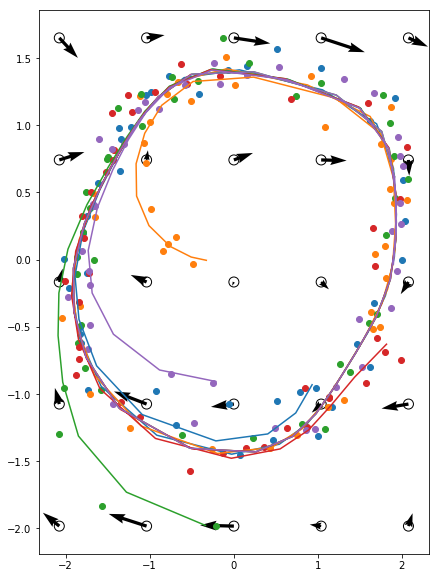

In [135]:
chain = sampler.samples[-400::10]
# plotting
mean_U = np.mean([i[0][0][0] for i in chain if i[1]], axis=0)

kreg.U.data = torch.from_numpy(mean_U)
mean_logsn = np.mean([i[0][0][1] for i in chain if i[1]], axis=0)
kreg.logsn.data = torch.from_numpy(mean_logsn)
xode = odeint(kreg, x0, t).detach().numpy()
# U = kreg.U.detach().numpy()
U = mean_U
Z = kreg.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    color=np.random.rand(3)
    plt.scatter(Y[i,:,0],Y[i,:,1],)
    plt.plot(xode[i,:,0],xode[i,:,1],'-')

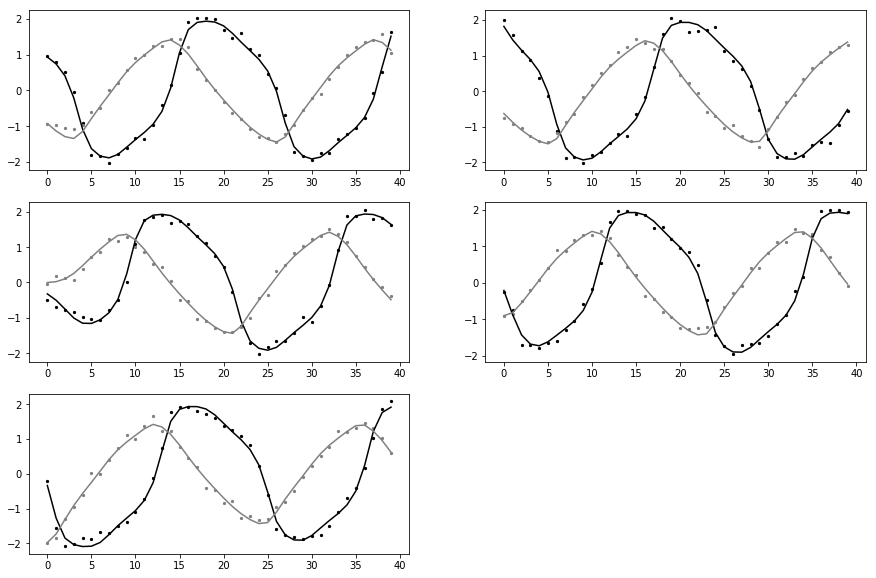

In [136]:
fig, ax = plt.subplots(nrows=(min(6,xode.shape[0])+1)//2, ncols=2, figsize=(15,10))
axes = [ax[i][j] for j in range(2) for i in range(len(ax))]
for i in range(min(6,xode.shape[0])):
    axes[i].scatter(range(len(Y[i,:,0])),Y[i,:,0],color='k',s=5)
    axes[i].plot(xode[i,:,0],'-',color='k')
    axes[i].scatter(range(len(Y[i,:,1])),Y[i,:,1],color='gray',s=5)
    axes[i].plot(xode[i,:,1],'-',color='gray')
for i in range(min(6,xode.shape[0]), len(axes)):
    fig.delaxes(axes[i])

In [28]:
plt.plot(logp_array[400:])

NameError: name 'logp_array' is not defined

In [149]:
R_= 2.5
x0_ = torch.from_numpy(2*R_*ss.uniform.rvs(size=[6,2])-R_)
# x0_ = x0
t_ = torch.linspace(0., 28., 160)
t_numpy = t_.clone().detach().numpy()

xode_gp = []
for i in range(len(sampler.samples[-400:-100:30])):
    kreg.U.data = torch.from_numpy(chain[i][0][0][0])
    xode_gp.append(odeint(kreg, x0_, t_).detach().numpy())
    xode_gp[-1] = np.transpose(xode_gp[-1],[1,0,2])
print(len(xode_gp))
    
xode_gp_mean = np.zeros_like(xode_gp[0])
xode_gp_std = np.zeros_like(xode_gp[0])

for i in range(xode_gp_mean.shape[0]):
    xode_gp_mean[i,:,0] = np.mean([xode_gp[j][i,:,0] for j in range(len(xode_gp))], axis=0)
    xode_gp_mean[i,:,1] = np.mean([xode_gp[j][i,:,1] for j in range(len(xode_gp))], axis=0)
    xode_gp_std[i,:,0] = np.std([xode_gp[j][i,:,0] for j in range(len(xode_gp))], axis=0)
    xode_gp_std[i,:,1] = np.std([xode_gp[j][i,:,1] for j in range(len(xode_gp))], axis=0)
    
    
xode_real = odeint(FHN(), x0_, t_).detach().numpy()
xode_real = np.transpose(xode_real,[1,0,2])

    

10


(6, 160, 2)
(6, 160, 2)
(6, 160, 2)


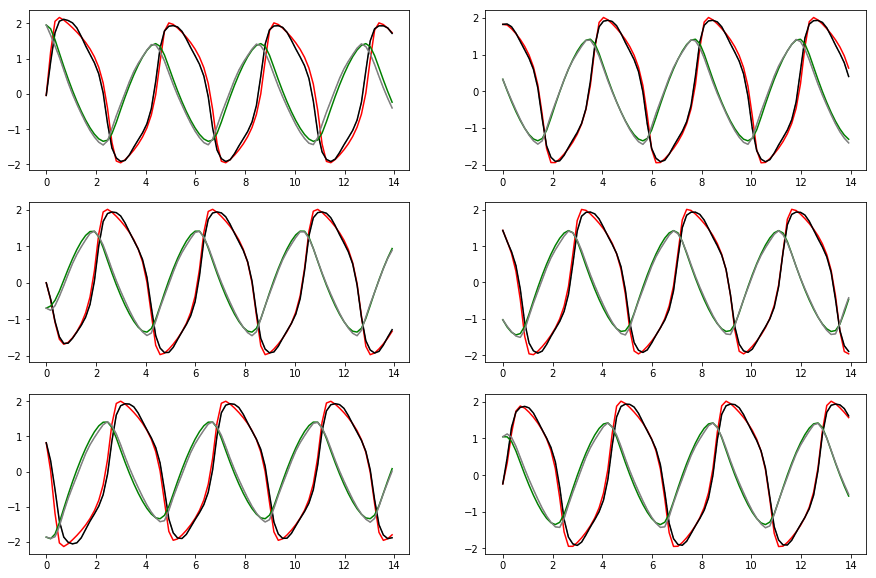

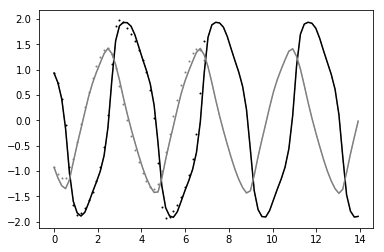

In [150]:
print(xode_gp_mean.shape)
print(xode_gp_std.shape)
print(xode_real.shape)


num_plots = 6
fig, ax = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15,10))
# fig, axes = plt.subplots(ncols=num_plots, nrows=1, figsize=(15,3))
axes = [ax[i][j] for j in range(2) for i in range(len(ax))]
for i in range(num_plots):
    axes[i].plot(t_numpy[:80],xode_real[i,0:80,0],'-',color='r')
    axes[i].fill_between(x=t_numpy[:80],
                         y1=xode_gp_mean[i,0:80,0]-5*xode_gp_std[i,0:80,0],
                         y2=xode_gp_mean[i,0:80,0]+5*xode_gp_std[i,0:80,0],
                         linestyle='--',color='k', alpha=0.3)
    axes[i].plot(t_numpy[:80],
                 xode_gp_mean[i,0:80,0],
                 linestyle='-',color='k')
    axes[i].plot(t_numpy[:80],xode_real[i,0:80,1],'-',color='g')
    axes[i].fill_between(x=t_numpy[:80],
                         y1=xode_gp_mean[i,0:80,1]-5*xode_gp_std[i,0:80,1],
                         y2=xode_gp_mean[i,0:80,1]+5*xode_gp_std[i,0:80,1],
                         linestyle='--',color='gray', alpha=0.3)
    axes[i].plot(t_numpy[:80],
                 xode_gp_mean[i,0:80,1],
                 linestyle='-',color='gray')
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])
    
fig, ax = plt.subplots()
ax.scatter(t_numpy[:40], X[0,:,0], color='k', s=1)
ax.scatter(t_numpy[:40], X[0,:,1], color='gray', s=1)


xode_gp = []

for i in range(len(chain)):
    kreg.U.data = torch.from_numpy(chain[i][0][0][0])
    xode_gp.append(odeint(kreg, x0, t_).detach().numpy())
    xode_gp[-1] = np.transpose(xode_gp[-1],[1,0,2])

xode_gp_mean = np.zeros_like(xode_gp[0])
xode_gp_std = np.zeros_like(xode_gp[0])

for i in range(xode_gp_mean.shape[0]):
    xode_gp_mean[i,:,0] = np.mean([xode_gp[j][i,:,0] for j in range(len(xode_gp))], axis=0)
    xode_gp_mean[i,:,1] = np.mean([xode_gp[j][i,:,1] for j in range(len(xode_gp))], axis=0)
    xode_gp_std[i,:,0] = np.std([xode_gp[j][i,:,0] for j in range(len(xode_gp))], axis=0)
    xode_gp_std[i,:,1] = np.std([xode_gp[j][i,:,1] for j in range(len(xode_gp))], axis=0)
    
ax.fill_between(x=t_numpy[:80],
                 y1=xode_gp_mean[0,0:80,0]-5*xode_gp_std[0,0:80,0],
                 y2=xode_gp_mean[0,0:80,0]+5*xode_gp_std[0,0:80,0],
                 linestyle='--',color='k', alpha=0.3)
ax.plot(t_numpy[:80],
         xode_gp_mean[0,0:80,0],
         linestyle='-',color='k')
ax.fill_between(x=t_numpy[:80],
                 y1=xode_gp_mean[0,0:80,1]-5*xode_gp_std[0,0:80,1],
                 y2=xode_gp_mean[0,0:80,1]+5*xode_gp_std[0,0:80,1],
                 linestyle='--',color='gray', alpha=0.3)
ax.plot(t_numpy[:80],
         xode_gp_mean[0,0:80,1],
         linestyle='-',color='gray')


In [ ]:
plt.plot([np.mean(np.exp(i[0][0][1])) for i in sampler.samples[:] if i[1]])
print(sampler.samples[10][0][0][1])


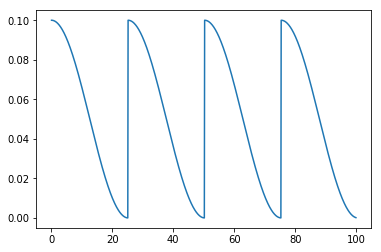

In [203]:
num_iters = 1000

def get_lr(t):
    r = _r(t)
    lr = 0.1/2.
    lr *= (np.cos(np.pi*r) + 1)
    return lr

def _r(t):
    M = 4
    return ((t-1)%((num_iters+M)//M))/((num_iters+M)//M)

t = np.arange(1,num_iters,1)
y = [get_lr(i) for i in t]

sns.lineplot(t/10, y)